In [1]:
import sys,os
import h5py

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from wgpack.config import DATAPATH,RDRPATH
from wgpack.adcp import readADCP_raw,motion_correct_ADCP_gps_h5py


In [2]:
# file path and name for input .PD0 file
fnam = "20210515_020002UTC_continuous_20210516.PD0"
adcp_filepath_in = os.path.join(DATAPATH,fnam)
# file path and name for output .mat file
fnam_out, file_extension = os.path.splitext(adcp_filepath_in)

# read-in ADCP binaries
adcpr = readADCP_raw(adcp_filepath_in, RDRPATH, adcp_filepath_out=fnam_out, eng_exit=True)


processing 20210515_020002UTC_continuous_20210516.PD0

Opening file /Users/a1amador/src/wgpack/data/20210515_020002UTC_continuous_20210516.PD0


***** Apparently a VMDAS file 


*****************************************************
Adjust location by 18 (readbytes=1230, hdr.nbyte=1246)
 NOTE - If this appears at the beginning of the read, it is
        is a program problem, possibly fixed by a fudge
        PLEASE REPORT TO rich@eos.ubc.ca WITH DETAILS!!

      -If this appears at the end of the file it means
       The file is corrupted and only a partial record has  
       has been read
******************************************************
Record begins at 16-May-0021 00:01:52
Ping interval appears to be  00:00:01

Estimating 8751 ensembles in this file
   Reading 8751 ensembles, reducing by a factor of 1
Final result 8751 values
.
*****************************************************
Adjust location by 18 (readbytes=1230, hdr.nbyte=1246)
 NOTE - If this appears at the beginning of

6350..................................................
6400..................................................
6450..................................................
6500..................................................
6550..................................................
6600..................................................
6650..................................................
6700..................................................
6750..................................................
6800..................................................
6850..................................................
6900..................................................
6950..................................................
7000..................................................
7050..................................................
7100..................................................
7150..................................................
7200..................................................
7250......

In [3]:
# read-in processed adcp data
hf = h5py.File(fnam_out+'.mat', 'r')
adcpr = hf['adcpr']

# apply motion correction
dt_gps = 120   # Time-averaging interval for GPS-derived velocities (s)
dt_avg = 120*3 # Time-averaging interval for motion-corrected ADCP velocities (s)
adcpm = motion_correct_ADCP_gps_h5py(adcpr, dt_gps, dt_avg)

print(adcpm.keys())


dict_keys(['time', 'longitude', 'latitude', 'ranges', 'Evel', 'Nvel', 'err_vel', 'Evelf', 'Nvelf', 'cog_gps', 'sog_gps', 'sog_gpse', 'sog_gpsn', 'heading_float', 'headingf_float'])


/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_1023/3714910181.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0,0].pcolormesh(x,y,U_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_1023/3714910181.py:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0,1].pcolormesh(x,y,V_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_1023/3714910181.py:5

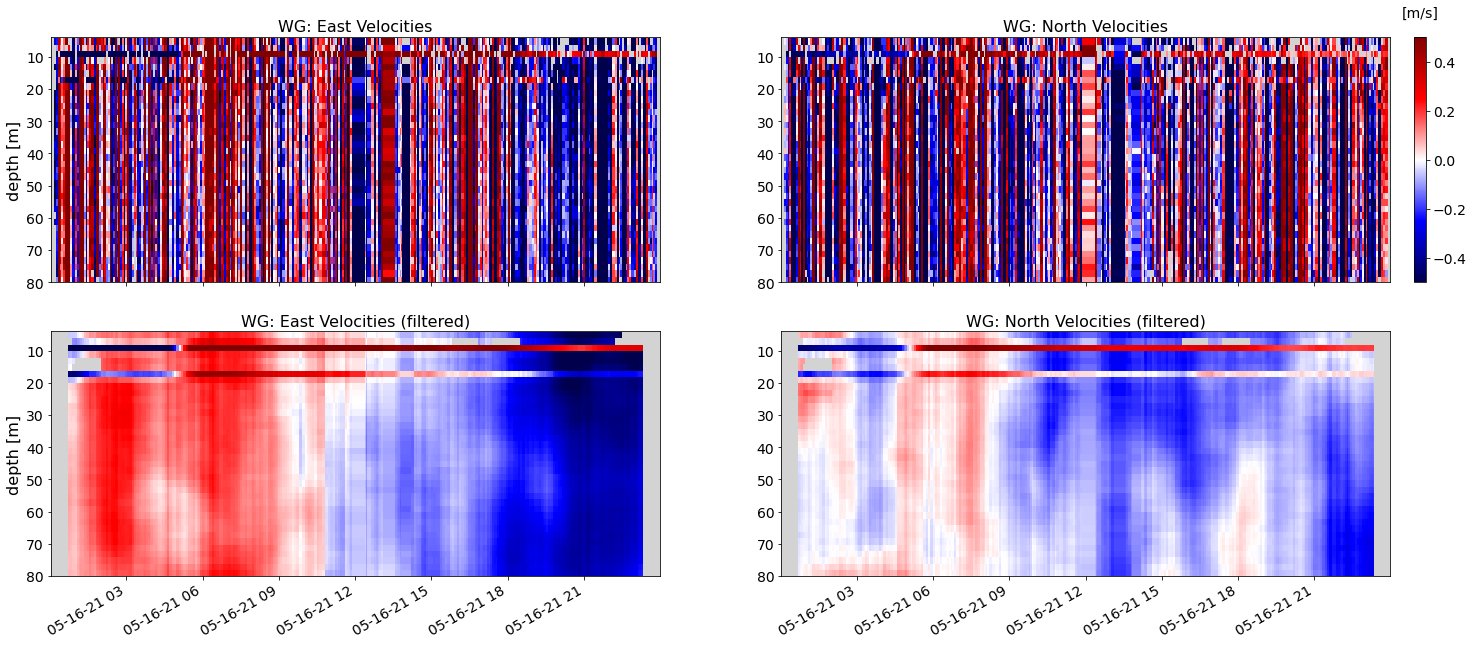

In [4]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot results
# ----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import numpy as np

# create masked colormap
cm_msk = plt.get_cmap('seismic').copy()
cm_msk.set_bad(color='lightgray')

tt_WG = adcpm['time']
ranges_WG = adcpm['ranges']
# motion-corrected velocities
U_WG = adcpm['Evel']
V_WG = adcpm['Nvel']
# motion-corrected and filtered velocities
Uf_WG = adcpm['Evelf']
Vf_WG = adcpm['Nvelf']

# Plot WG water velocities
yL = [4,80]
uL = 0.5
vL = 0.5
fntsz = 16
labsz = 14
ylab_str = 'depth [m]'

# Do not show vehicle heading
heights = [1,1]
nrows = 2
ncols = 2
gs_kw = dict(height_ratios=heights)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                            sharex=True,
                            sharey=False,
                            gridspec_kw=gs_kw,
                            figsize=(24, 11))


# WG: East Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
c = ax[0,0].pcolormesh(x,y,U_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[0,0].set_ylim(yL)
ax[0,0].set_ylabel(ylab_str,fontsize=fntsz)
ax[0,0].set_title('WG: East Velocities',fontsize=fntsz)
ax[0,0].invert_yaxis()

# WG: North Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
ax[0,1].pcolormesh(x,y,V_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[0,1].set_ylim(yL)
ax[0,1].set_title('WG: North Velocities',fontsize=fntsz)
ax[0,1].invert_yaxis()

# WG: East Vel (filtered)
x,y = np.meshgrid(tt_WG,ranges_WG)
c = ax[1,0].pcolormesh(x,y,Uf_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[1,0].set_ylim(yL)
ax[1,0].set_ylabel(ylab_str,fontsize=fntsz)
ax[1,0].set_title('WG: East Velocities (filtered)',fontsize=fntsz)
ax[1,0].invert_yaxis()

# WG: North Vel (filtered)
x,y = np.meshgrid(tt_WG,ranges_WG)
ax[1,1].pcolormesh(x,y,Vf_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[1,1].set_ylim(yL)
ax[1,1].set_title('WG: North Velocities (filtered)',fontsize=fntsz)
ax[1,1].invert_yaxis()

# rotate and align the tick labels so they look better
ax[0,0].tick_params(labelsize=labsz)
ax[1,0].tick_params(labelsize=labsz)
ax[0,1].tick_params(labelsize=labsz)
ax[1,1].tick_params(labelsize=labsz)

# Define the date format
date_form = DateFormatter("%m-%d-%y %H")
ax[1,1].xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

# add a colorobar
gs = gridspec.GridSpec(ncols=3, nrows=nrows, height_ratios=gs_kw['height_ratios'], right=0.95,figure=fig)
axc = fig.add_subplot(gs[0,-1])
axc.set_visible(False)
cbar = fig.colorbar(c, ax=axc,orientation='vertical')
cax = cbar.ax
# Add label on top of colorbar.
cbar.ax.set_xlabel("[m/s]\n",fontsize=labsz)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=labsz)

fig.show()

/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_88004/3438212531.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0].pcolormesh(x,y,Uf_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_88004/3438212531.py:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(x,y,Vf_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_88004/3438212531.py:

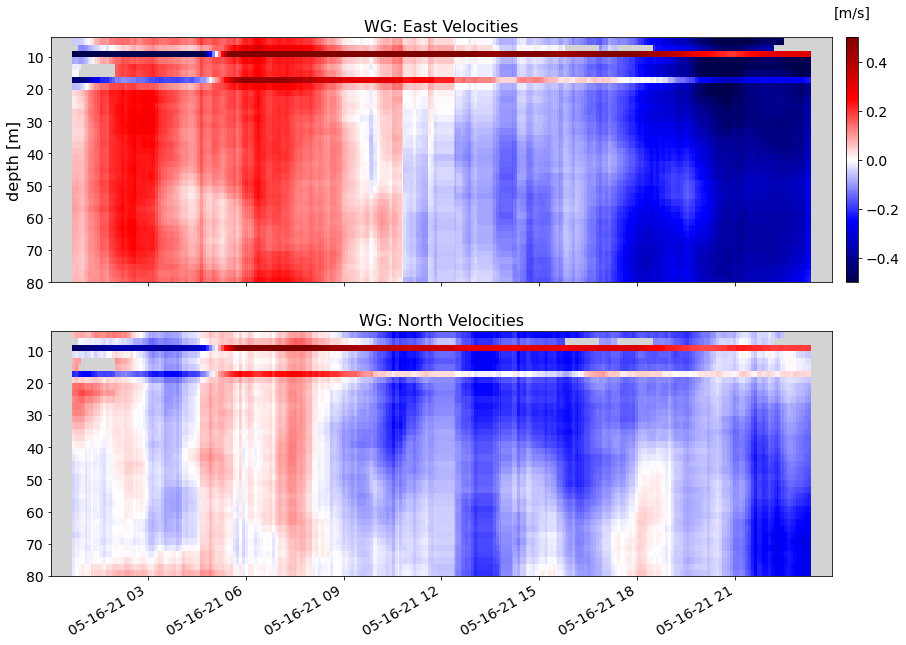

In [31]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot results
# ----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import numpy as np

# create masked colormap
cm_msk = plt.get_cmap('seismic').copy()
cm_msk.set_bad(color='lightgray')

tt_WG = adcpm['time']
ranges_WG = adcpm['ranges']
# motion-corrected velocities
U_WG = adcpm['Evel']
V_WG = adcpm['Nvel']
# motion-corrected and filtered velocities
Uf_WG = adcpm['Evelf']
Vf_WG = adcpm['Nvelf']

# Plot WG water velocities
yL = [4,80]
uL = 0.5
vL = 0.5
fntsz = 16
labsz = 14
ylab_str = 'depth [m]'

# Do not show vehicle heading
heights = [1,1]
nrows = 2
ncols = 1
gs_kw = dict(height_ratios=heights)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                            sharex=True,
                            sharey=False,
                            gridspec_kw=gs_kw,
                            figsize=(14, 11))


# WG: East Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
c = ax[0].pcolormesh(x,y,Uf_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[0].set_ylim(yL)
ax[0].set_ylabel(ylab_str,fontsize=fntsz)
ax[0].set_title('WG: East Velocities',fontsize=fntsz)
ax[0].invert_yaxis()

# WG: North Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
ax[1].pcolormesh(x,y,Vf_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[1].set_ylim(yL)
ax[1].set_title('WG: North Velocities',fontsize=fntsz)
ax[1].invert_yaxis()


# rotate and align the tick labels so they look better
ax[0].tick_params(labelsize=labsz)
ax[1].tick_params(labelsize=labsz)

# Define the date format
date_form = DateFormatter("%m-%d-%y %H")
ax[1].xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

# add a colorobar
gs = gridspec.GridSpec(ncols=3, nrows=nrows, height_ratios=gs_kw['height_ratios'], right=0.95,figure=fig)
axc = fig.add_subplot(gs[0,-1])
axc.set_visible(False)
cbar = fig.colorbar(c, ax=axc,orientation='vertical')
cax = cbar.ax
# Add label on top of colorbar.
cbar.ax.set_xlabel("[m/s]\n",fontsize=labsz)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=labsz)

fig.show()

In [4]:
# import os
# SCPATH = '/Volumes'
# seachest_data_dir = os.path.join(SCPATH,'cordc-data/PROJECTS/WAVEGLIDER')
# vnam = 'sv3-022'

# # ----------------------------------------------------------------------------------------------------------------------
# # Processing
# # ----------------------------------------------------------------------------------------------------------------------
# # file path and name for input .PD0 file
# # Update wind data - need to be on VPN (sio-terrill pool) and SeaChest needs to be mounted on local machine
# REMOTEdir = os.path.join(seachest_data_dir,vnam,'current/nrt/adcp')
# f = []
# for (dirpath, dirnames, filenames) in os.walk(REMOTEdir):
#     f.extend(filenames)
#     break
# f.sort()
# print(f)


['20220111_055728UTC_continuous.PD0', '20220111_055728UTC_continuous.mat', '20220111_055728UTC_continuous_20220111.PD0', '20220111_055728UTC_continuous_20220111.mat', '20220112_011237UTC_continuous.PD0', '20220112_011237UTC_continuous.mat', '20220112_011237UTC_continuous_20220112.PD0', '20220112_011237UTC_continuous_20220112.mat', '20220113_013000UTC_continuous.PD0', '20220113_013000UTC_continuous.mat', '20220113_013000UTC_continuous_20220113.PD0', '20220113_013000UTC_continuous_20220113.mat', '20220113_040001UTC_continuous.PD0', '20220113_040001UTC_continuous.mat', '20220113_040001UTC_continuous_20220113.PD0', '20220113_040001UTC_continuous_20220113.mat', '20220113_040001UTC_continuous_20220114.PD0', '20220113_040001UTC_continuous_20220114.mat', '20220113_040001UTC_continuous_20220115.PD0', '20220113_040001UTC_continuous_20220115.mat']


In [17]:
# os.path.getmtime(os.path.join(REMOTEdir,f[-2]))
# fnam_out

'/Volumes/cordc-data/PROJECTS/WAVEGLIDER/sv3-022/current/nrt/adcp/20220113_040001UTC_continuous_20220115'

In [5]:
# # -------------------------------------------------------------------------------------
# # Process raw ADPC binaries
# # -------------------------------------------------------------------------------------
# for fnam in f:
#     adcp_filepath_in = os.path.join(REMOTEdir, fnam)
#     print(adcp_filepath_in)
#     # file path and name for output .mat file
#     fnam_out, file_extension = os.path.splitext(adcp_filepath_in)
#     if not os.path.exists(fnam_out+'.mat'):
#         # read-in ADCP binaries
#         adcpr = readADCP_raw(adcp_filepath_in, RDRPATH, adcp_filepath_out=fnam_out, eng_exit=True)
#     elif os.path.getmtime(fnam_out+'.mat')<os.path.getmtime(fnam_out+'.PD0'):
#         print('Updating')
#         print(fnam_out+'.mat')
#         # read-in ADCP binaries
#         adcpr = readADCP_raw(adcp_filepath_in, RDRPATH, adcp_filepath_out=fnam_out, eng_exit=True)